# IHS locus artwork

## Setup

In [1]:
%run locus-artwork-setup.ipynb

In [2]:
def plot_signal_percentiles(pop, window_size=50, window_step=50):
    fig, ax = plt.subplots(facecolor='w', figsize=(9, 3))
    
    # plot each chromosome
    x = list(range(90, 100)) + [99.5, 99.9]
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, signal, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(signal)
        # plot 
        y = [np.percentile(signal, i) for i in x]
        ax.plot(x, y, marker='o', label=chromosome)
        
    # plot all
    signal = np.concatenate(all_vals)
    y = [np.percentile(signal, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
    ax.set_ylim(bottom=2, top=8)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$|IHS|_{max}$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

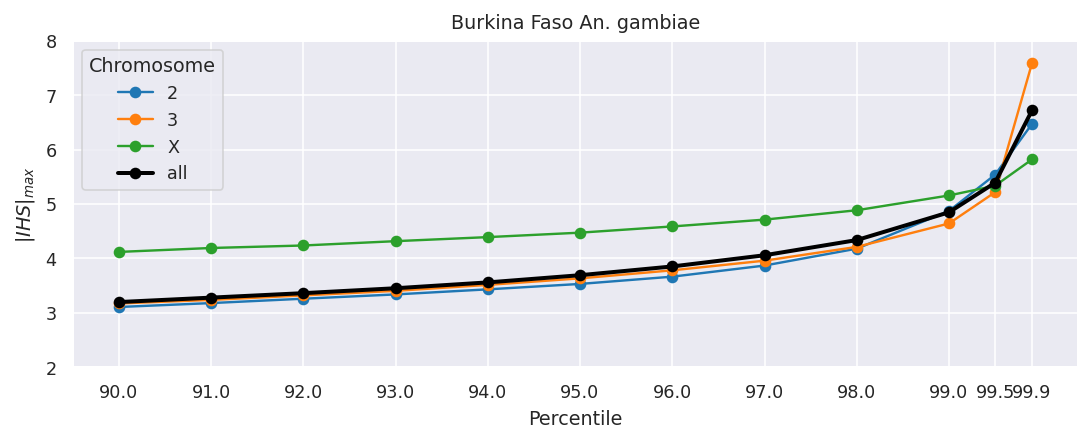

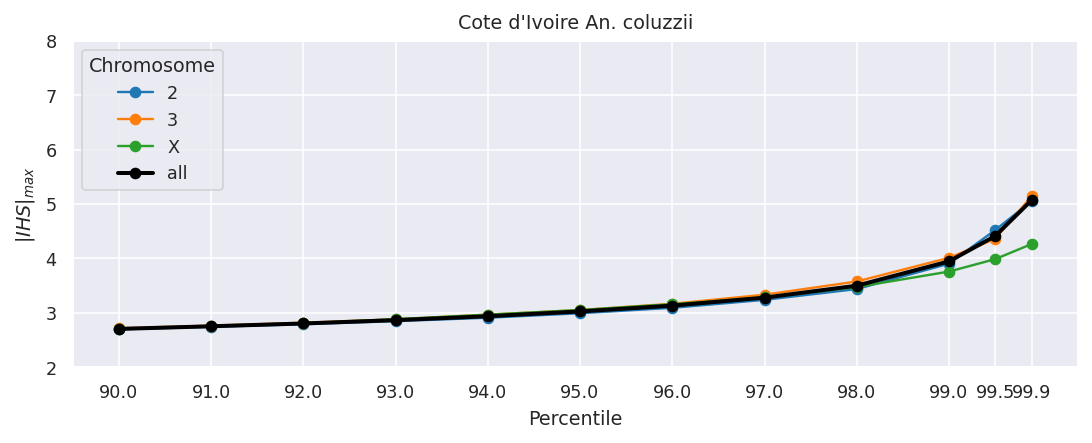

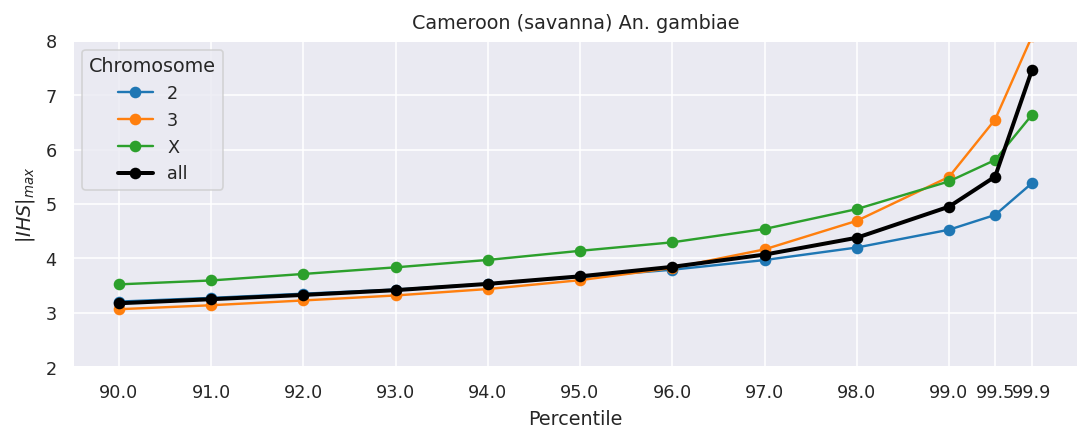

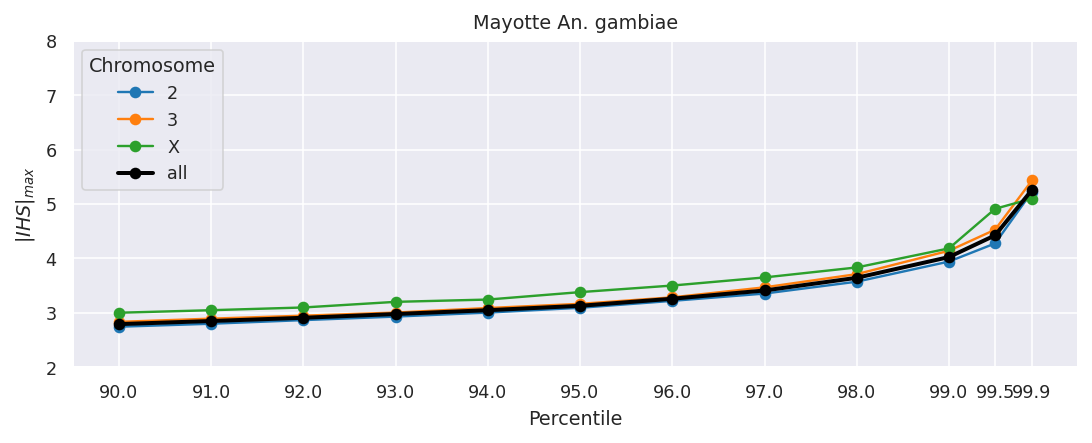

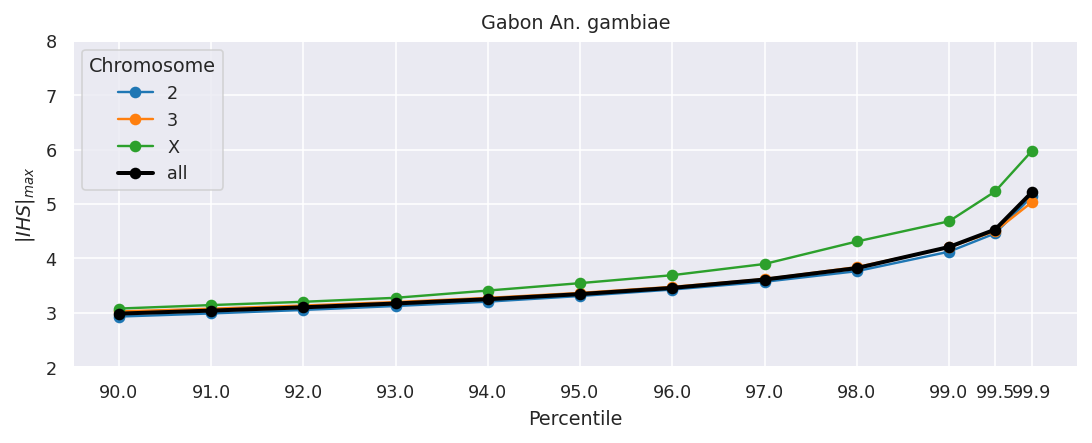

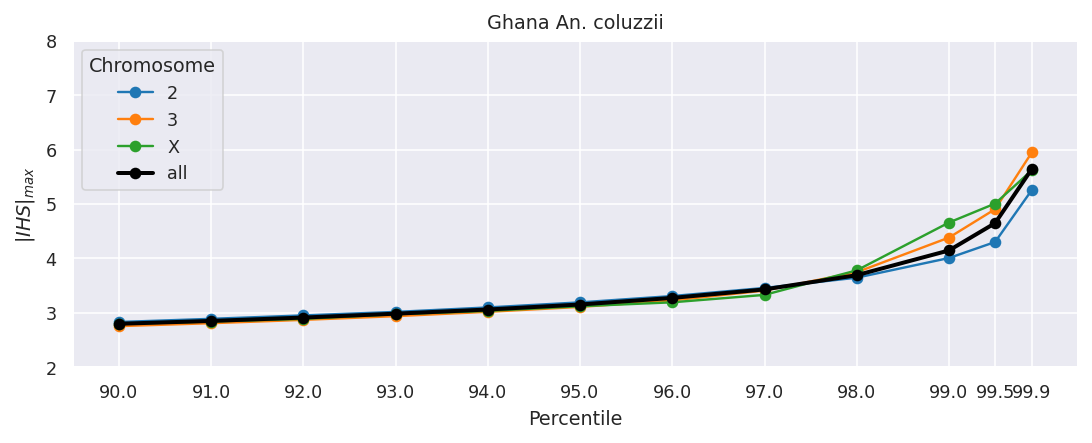

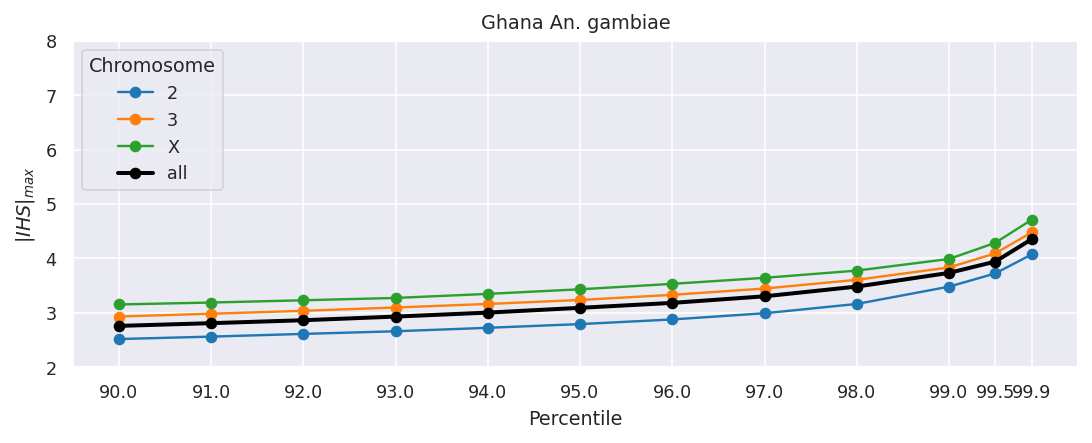

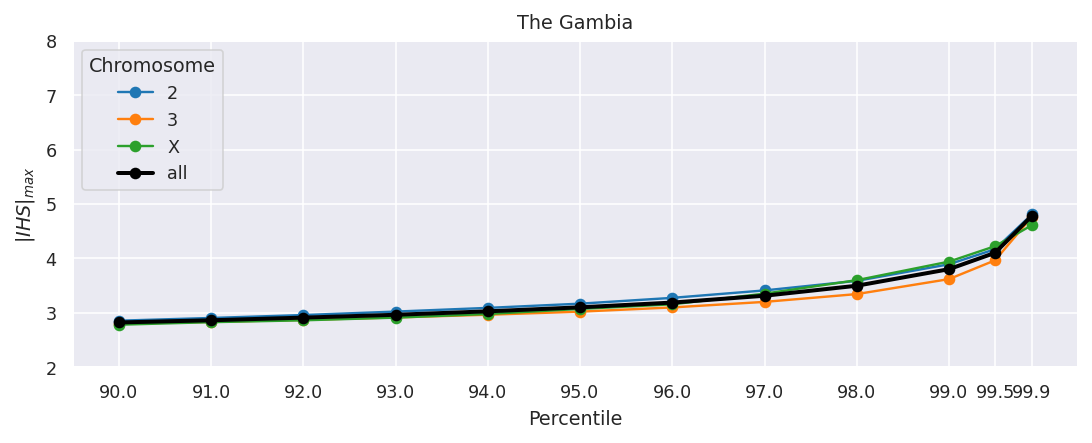

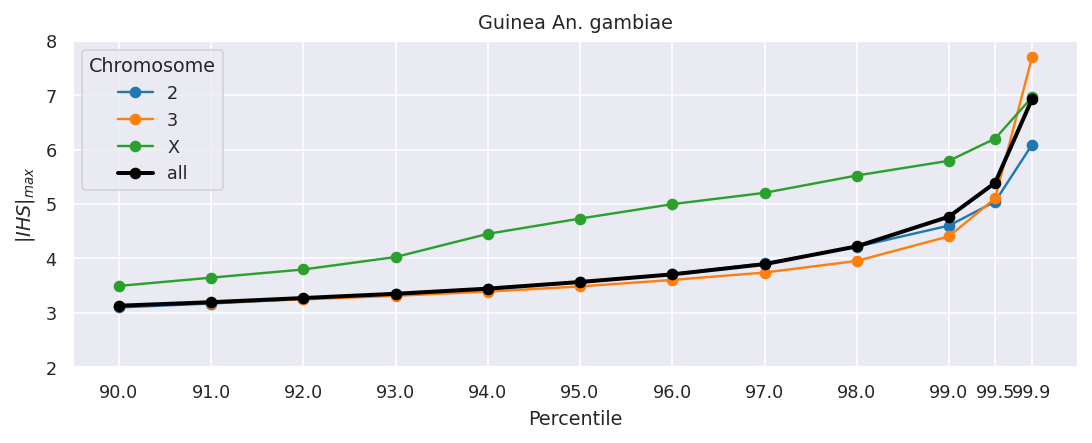

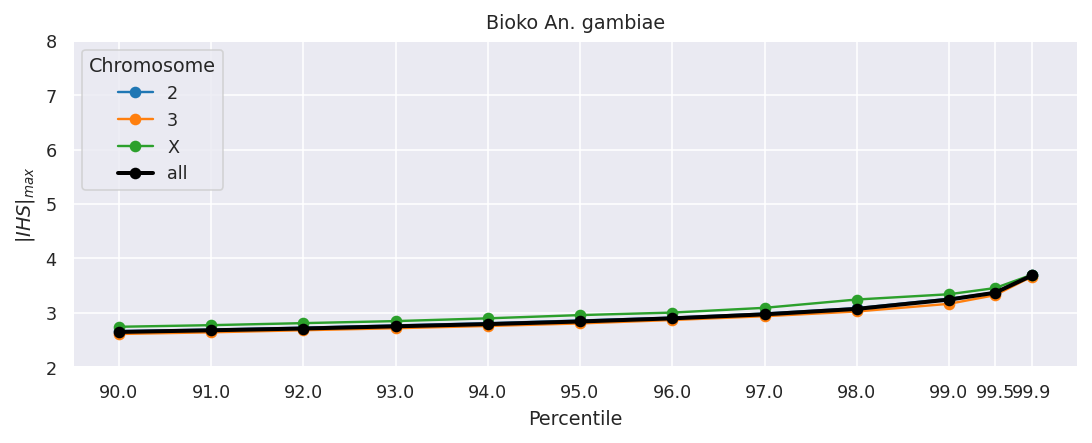

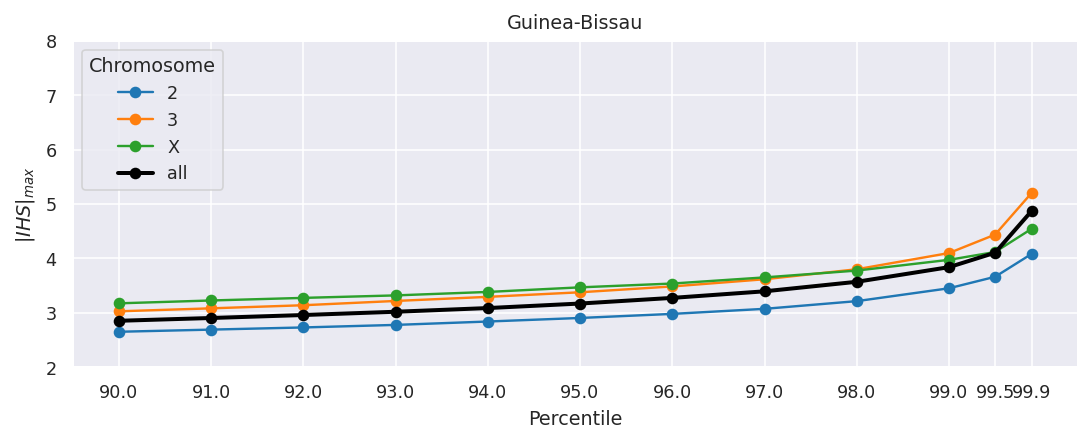

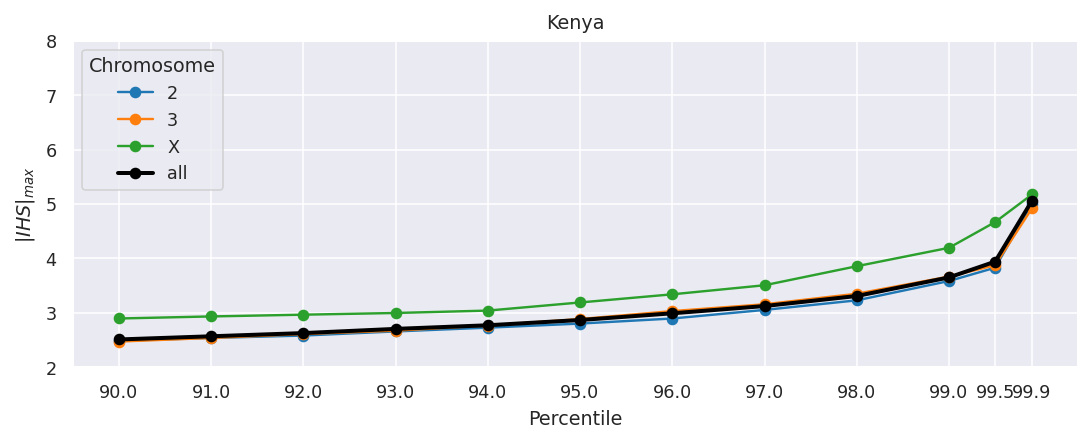

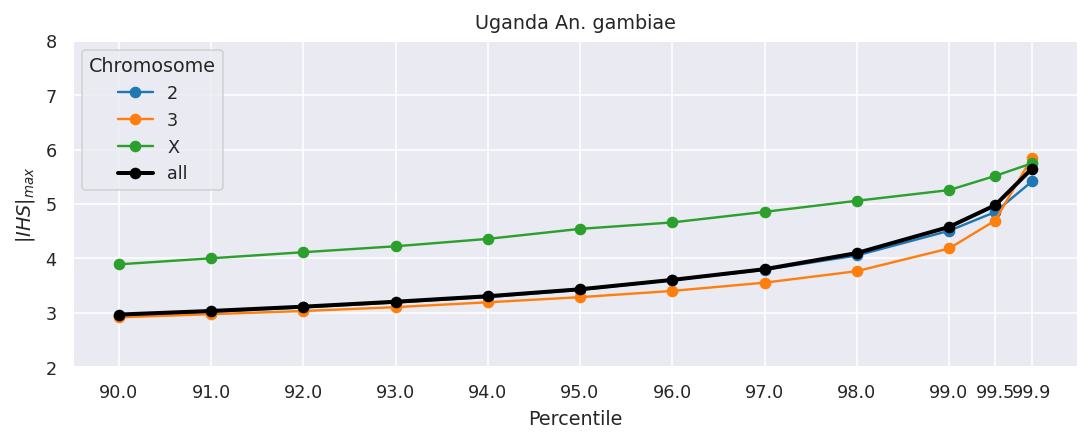

In [3]:
for pop in pop_defs:
    plot_signal_percentiles(pop)

In [4]:
@functools.lru_cache(maxsize=None)
def get_signal_percentile(pop, q, window_size, window_step):
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, signal, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(signal)
    signal = np.concatenate(all_vals)
    return np.percentile(signal, q)
    

In [5]:
get_signal_percentile('bf_gam', 99, window_size=50, window_step=50)

4.84588895871614

In [6]:
def plot_signal(pop, chromosome, center, flank, ax=None, markersize=2, 
                 window_size=50, window_step=50,
                 legend=False, label=True, ymax=None, genetic_distance=False,
                 percentiles=[98], has_peak_n=20,
                 has_peak_dist=.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
    else:
        raise ValueError

    # load gwss data
    p, gp, signal, _, _, _ = load_ihs_gwss(
        pop, chromosome, window_size=window_size, window_step=window_step
    )
    p = p/1e6
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p

    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_signal_percentile(pop, q, window_size=window_size, 
                                   window_step=window_step)
        qvals.append(v)
        ax.axhline(v, color='k', linestyle='--', lw=.5)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot gwss data
    palette = sns.color_palette()
    ax.plot(x, signal, marker='o', linestyle=' ', 
            markersize=markersize, color=palette[3])

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(1.1*max(qvals), 1.1*np.max(signal[loc_xlim]))
    ax.set_ylim(1, ymax)
    ax.set_ylabel('$|IHS|$')
            
    # statistics
    has_peak = False
    try:
        loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
        has_peak = np.count_nonzero(signal[loc_peak_test] > qvals[-1]) > has_peak_n
    except KeyError:
        pass
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        peak_value = np.max(signal[loc_region])
        peak_pos = p[loc_region][np.argmax(signal[loc_region])] - center
        statistics = dict(
            pop=pop,
            peak_value=peak_value,
            peak_pos=peak_pos
        )
    else:
        statistics = dict(
            pop=pop,
            peak_value=np.nan,
            peak_pos=np.nan,
        )
    
    if label:
        pop_label = (
            pop_defs[pop]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        if has_peak:
            annotation = (
                f"{pop_label}\n$"
                f"|IHS|_{{peak}}={peak_value:.1f}$\n"
                f"$pos(|IHS|_{{peak}})={peak_pos*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xytext=(8, -8), 
                    xycoords='axes fraction', textcoords='offset points', 
                    fontsize=8, va='top', ha='left', backgroundcolor='white')
    
    return statistics


{'pop': 'bf_gam', 'peak_value': nan, 'peak_pos': nan}

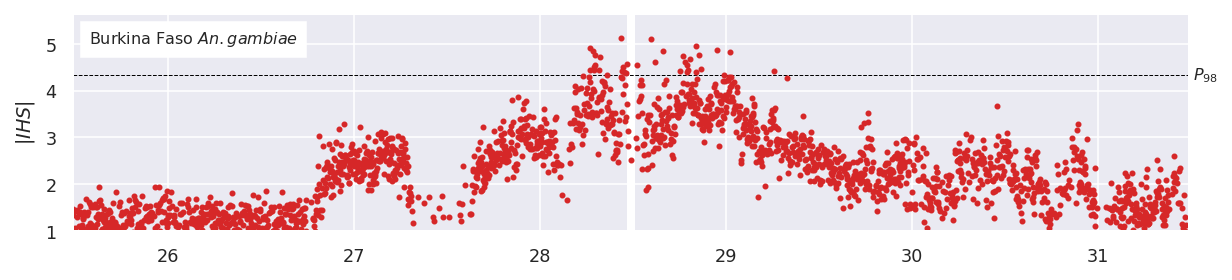

In [7]:
plot_signal('bf_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'gn_gam',
 'peak_value': 5.579563993087699,
 'peak_pos': 0.27740890000000107}

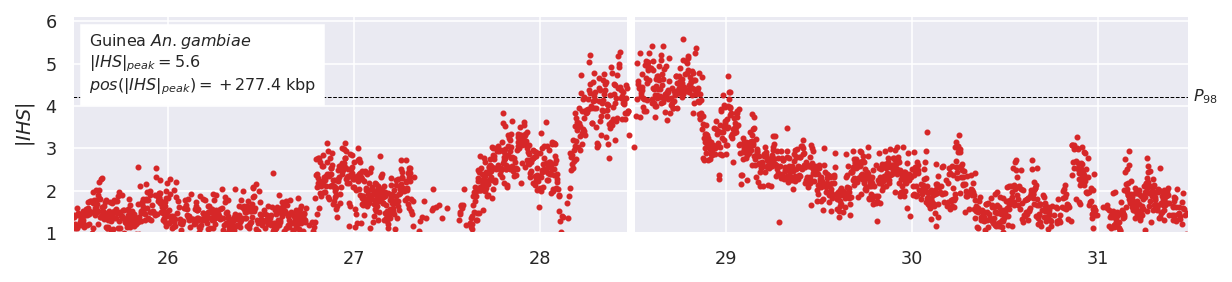

In [8]:
plot_signal('gn_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'bf_col', 'peak_value': nan, 'peak_pos': nan}

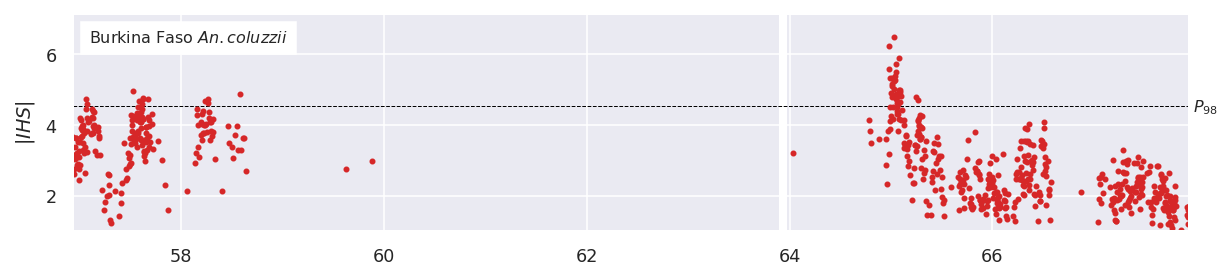

In [9]:
plot_signal('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
             flank=(7, 4))

{'pop': 'bf_col', 'peak_value': nan, 'peak_pos': nan}

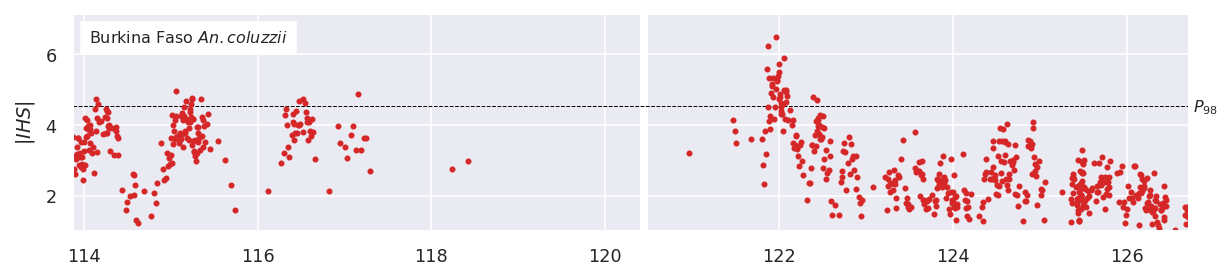

In [10]:
plot_signal('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
             flank=(7, 4), genetic_distance=True)

In [24]:
all_stats = dict()


def analyse_gene(gene, flank=3, genetic_distance=False):
    
    # first pass, plot all populations
    df_stats = fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'], track_height=2, 
        genetic_distance=genetic_distance,
        plot_kwargs=dict(ymax=10),
        tracks=(
            (plot_signal, dict(pop='bf_gam')),
            (plot_signal, dict(pop='gn_gam')),
            (plot_signal, dict(pop='gh_gam')),
            (plot_signal, dict(pop='cm_sav_gam')),
            (plot_signal, dict(pop='ug_gam')),
            (plot_signal, dict(pop='ga_gam')),
            (plot_signal, dict(pop='gq_gam')),
            (plot_signal, dict(pop='fr_gam')),
            (plot_signal, dict(pop='bf_col')),
            (plot_signal, dict(pop='ci_col')),
            (plot_signal, dict(pop='gh_col')),
            (plot_signal, dict(pop='ao_col')),
            (plot_signal, dict(pop='gw')),
            (plot_signal, dict(pop='gm')),
            (plot_signal, dict(pop='ke')),
        ),
    )
    plt.show()
    plt.close()
    
    # store stats
    all_stats[gene['Name'].lower()] = df_stats
    
    # find pops with peak
    peak_pops = df_stats[~df_stats.peak_value.isna()]['pop'].values
    
    if len(peak_pops) < 6:
        track_height = 2.3
    else:
        track_height = None

    # second pass, plot only pops with a peak
    fig_locus(
        chromosome=gene.chromosome, center=gene.chromosome_center/1e6, 
        flank=flank, label=gene['Name'],
        genetic_distance=genetic_distance,
        track_height=track_height,
        tracks=[(plot_signal, dict(pop=pop)) for pop in peak_pops],
        plot_kwargs=dict(ymax=df_stats['peak_value'].max()*1.03),
        savefig=here() / f"artwork/locus_{gene['Name'].lower()}_ihs_{'g' if genetic_distance else 'p'}dist.png"
    )  
    plt.show()
    plt.close()
    

## *Gste2*

In [25]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

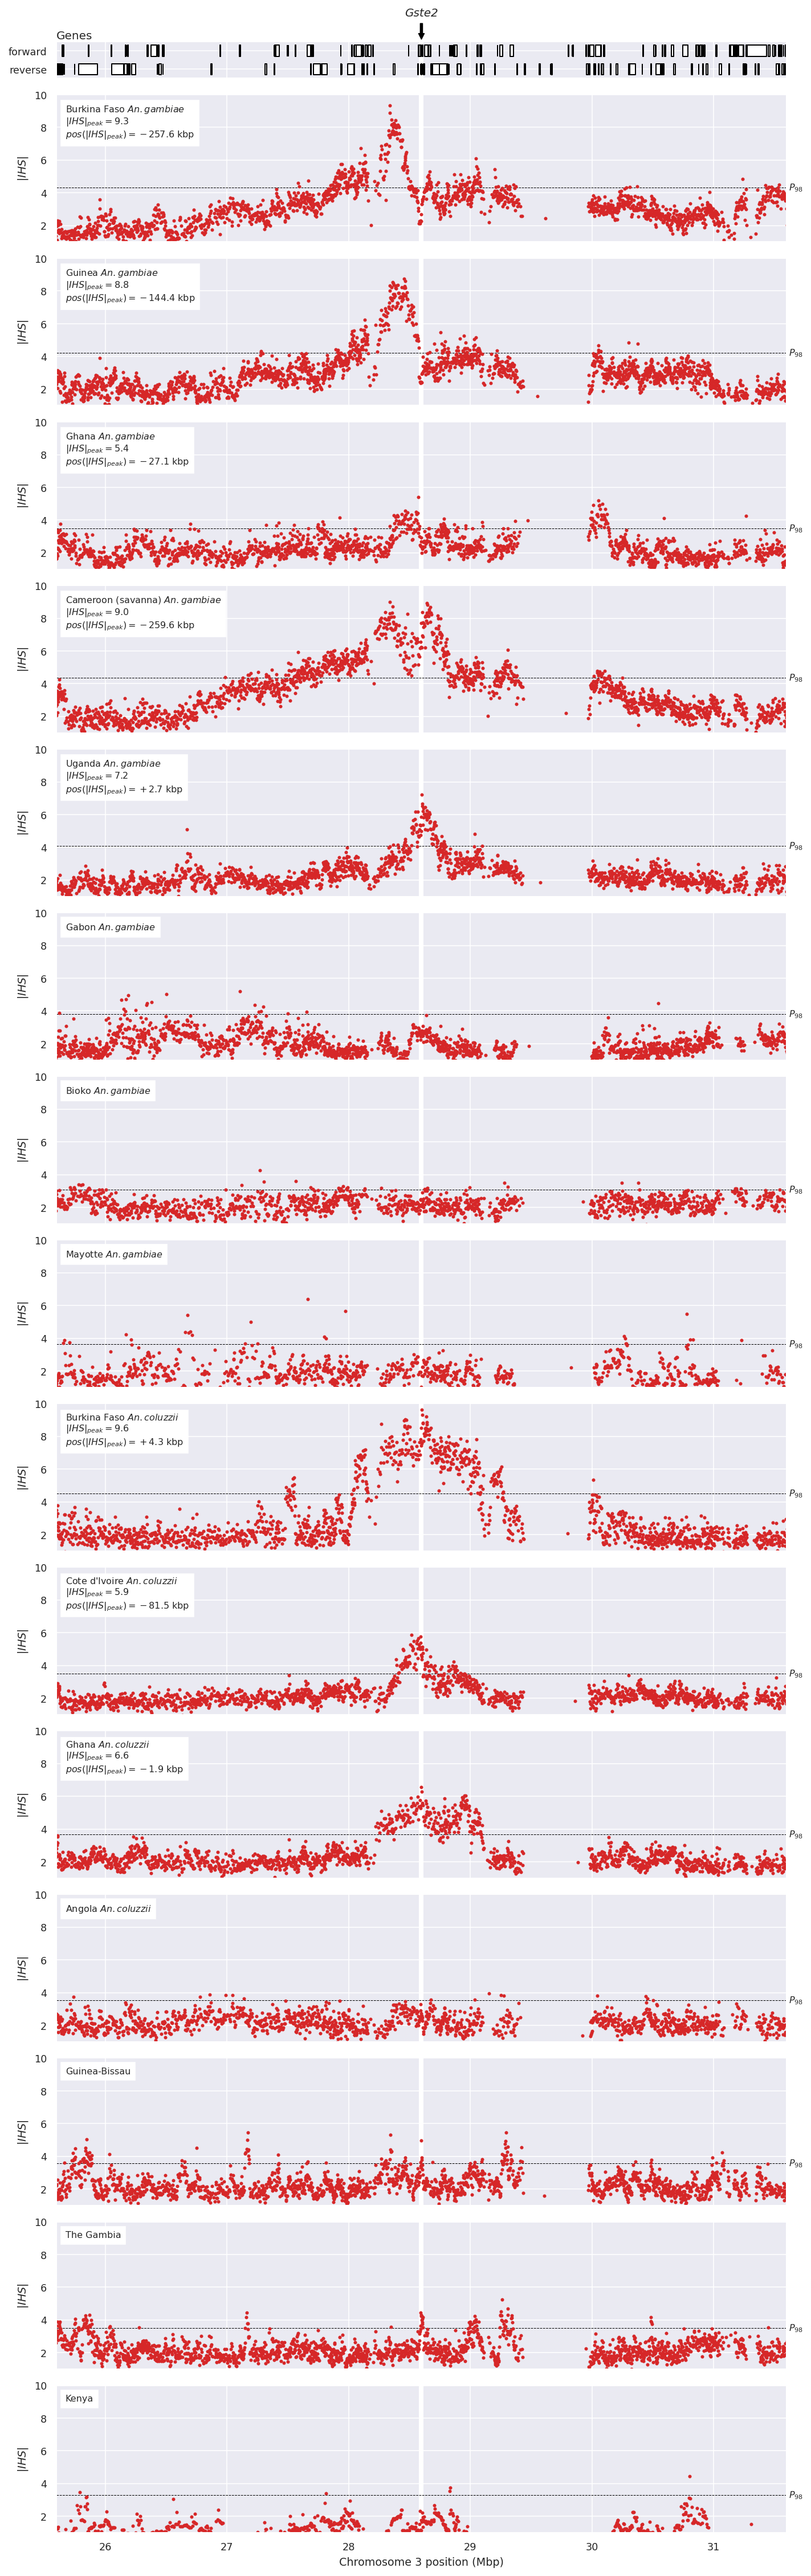

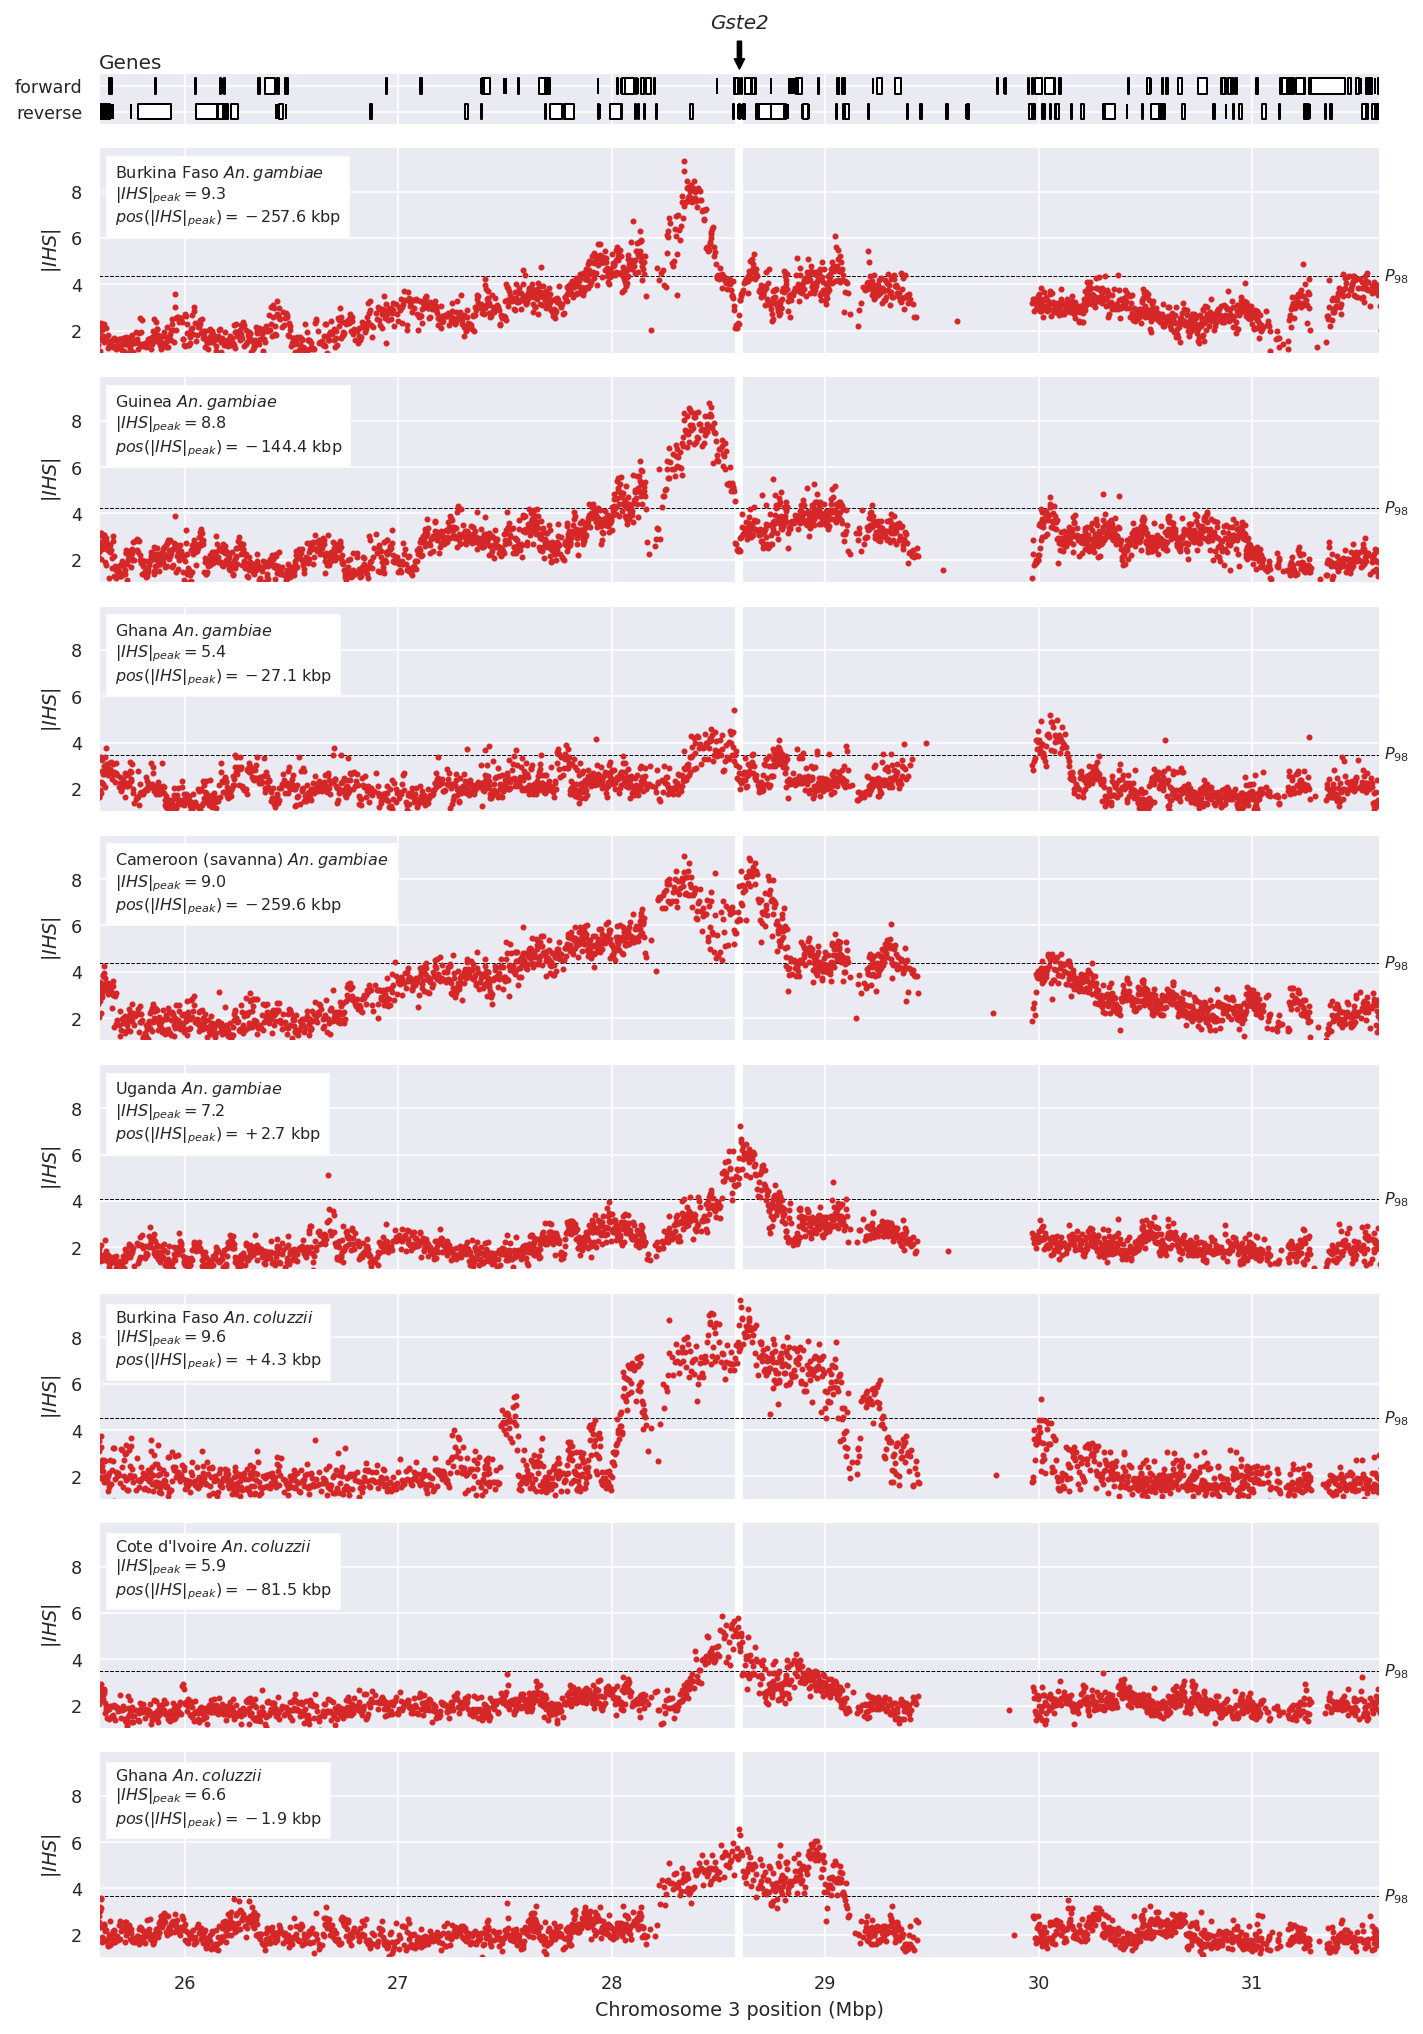

In [26]:
analyse_gene(gste2)

## *Cyp6p3*

In [27]:
cyp6p3

seqid                            2R
source                   VectorBase
type                           gene
start                      28491415
end                        28493141
score                            -1
strand                            -
phase                            -1
Name                         Cyp6p3
biotype              protein_coding
chromosome                        2
chromosome_start           28491415
chromosome_end             28493141
chromosome_center       2.84923e+07
Name: AGAP002865, dtype: object

In [28]:
analyse_gene(cyp6p3)

## *Cyp9k1*

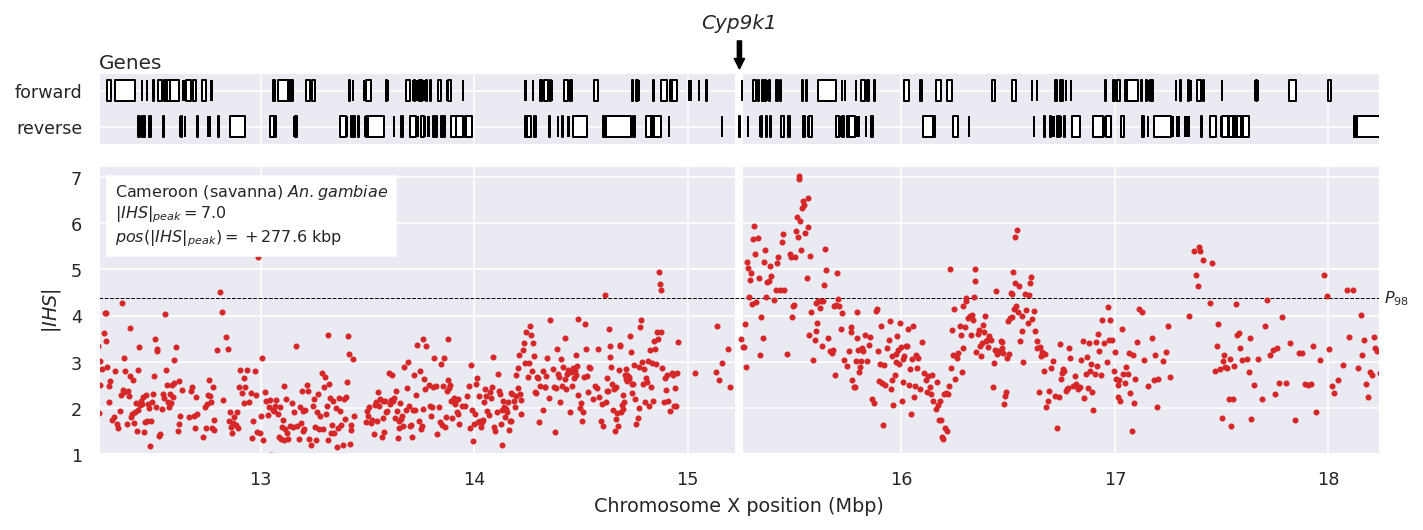

In [29]:
analyse_gene(cyp9k1)

## *Vgsc*

In [30]:
vgsc

seqid                            2L
source                   VectorBase
type                           gene
start                       2358158
end                         2431617
score                            -1
strand                            +
phase                            -1
Name                           Vgsc
biotype              protein_coding
chromosome                        2
chromosome_start           63903263
chromosome_end             63976722
chromosome_center         6.394e+07
Name: AGAP004707, dtype: object

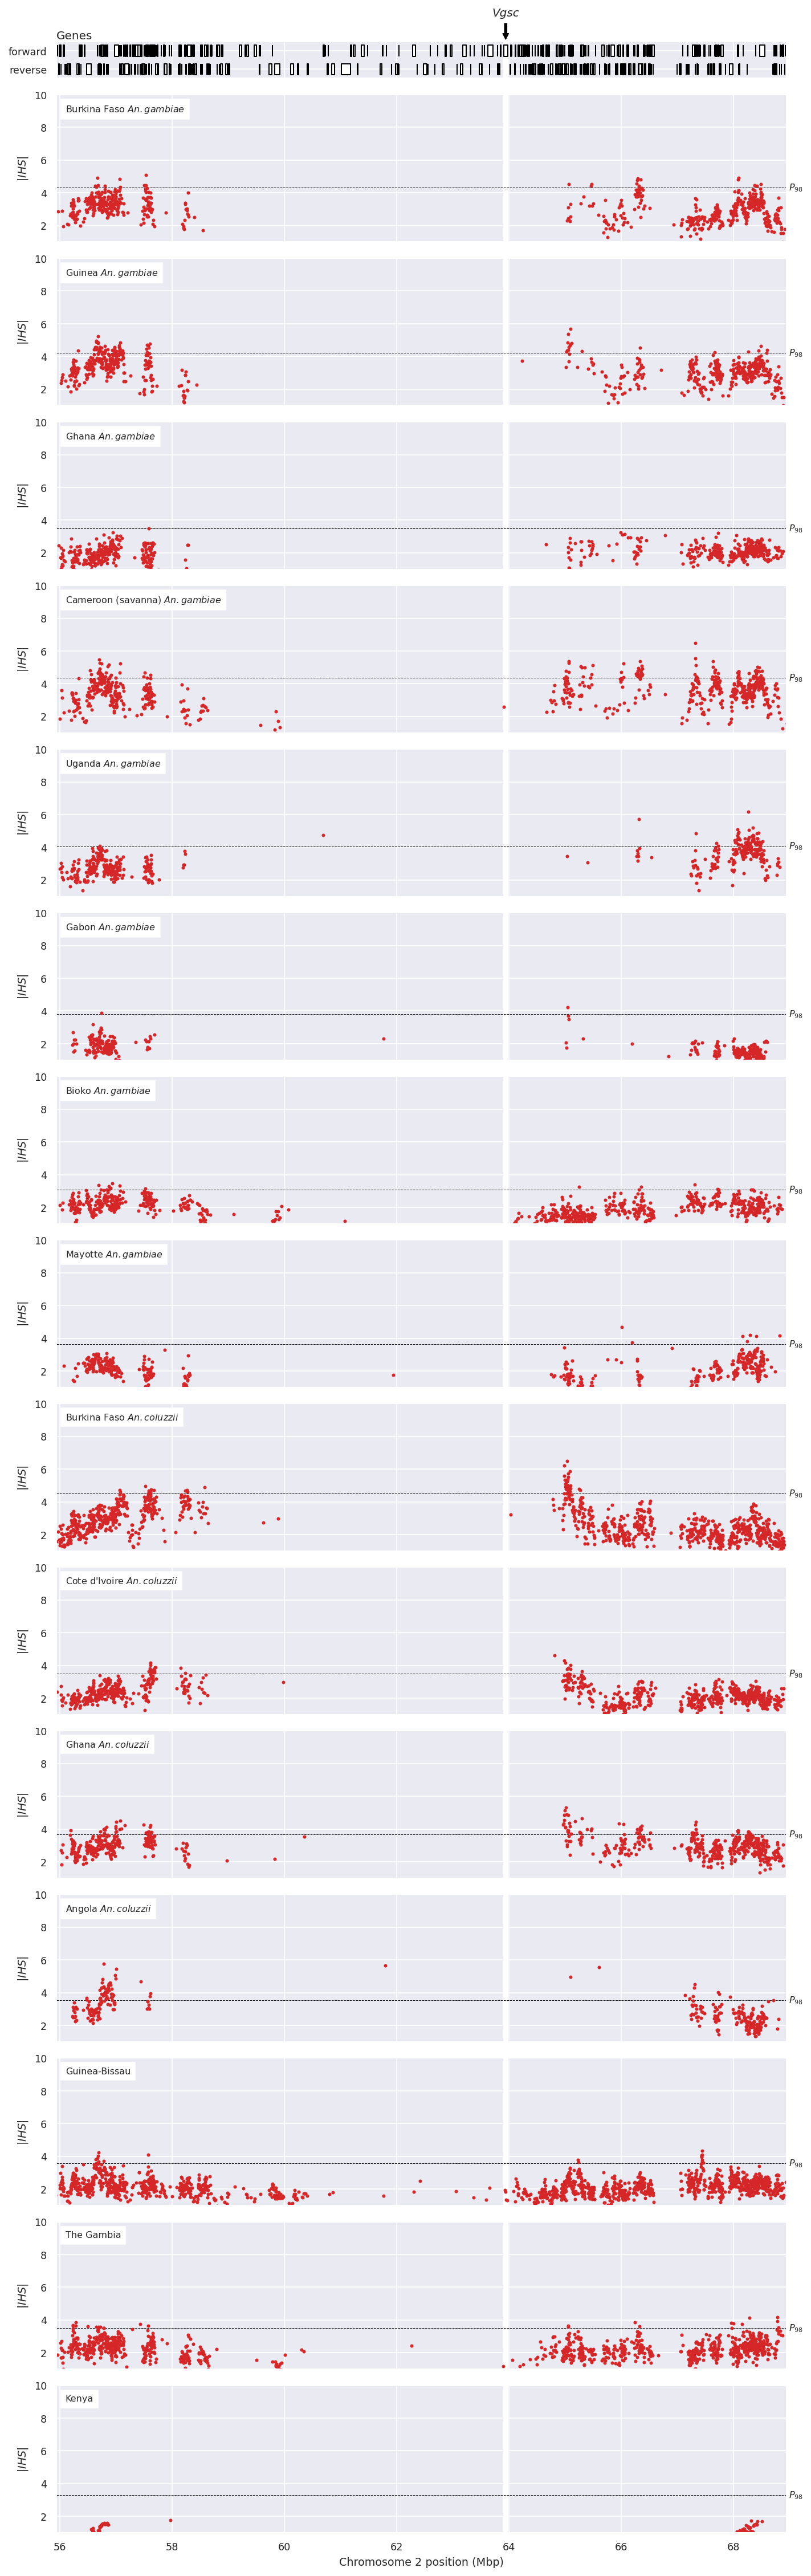

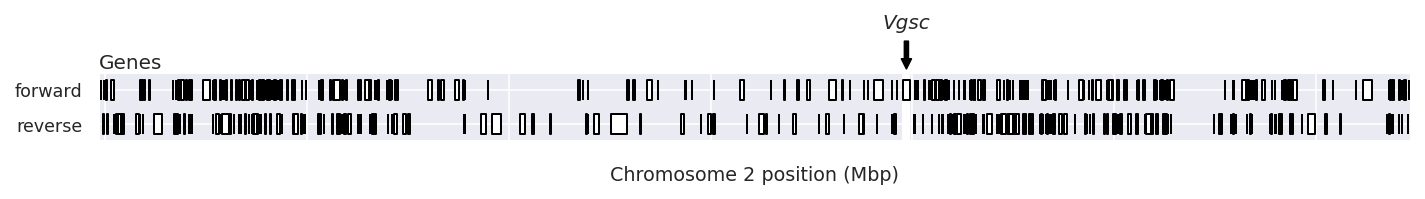

In [31]:
analyse_gene(vgsc, flank=(8, 5))

## *Gaba*

In [32]:
gaba

seqid                            2L
source                   VectorBase
type                           gene
start                      25363652
end                        25434556
score                            -1
strand                            +
phase                            -1
Name                           Gaba
biotype              protein_coding
chromosome                        2
chromosome_start           86908757
chromosome_end             86979661
chromosome_center       8.69442e+07
Name: AGAP006028, dtype: object

In [33]:
analyse_gene(gaba)

## *Ace1*

In [34]:
ace1

seqid                            2R
source                   VectorBase
type                           gene
start                       3483099
end                         3497400
score                            -1
strand                            +
phase                            -1
Name                           Ace1
biotype              protein_coding
chromosome                        2
chromosome_start            3483099
chromosome_end              3497400
chromosome_center       3.49025e+06
Name: AGAP001356, dtype: object

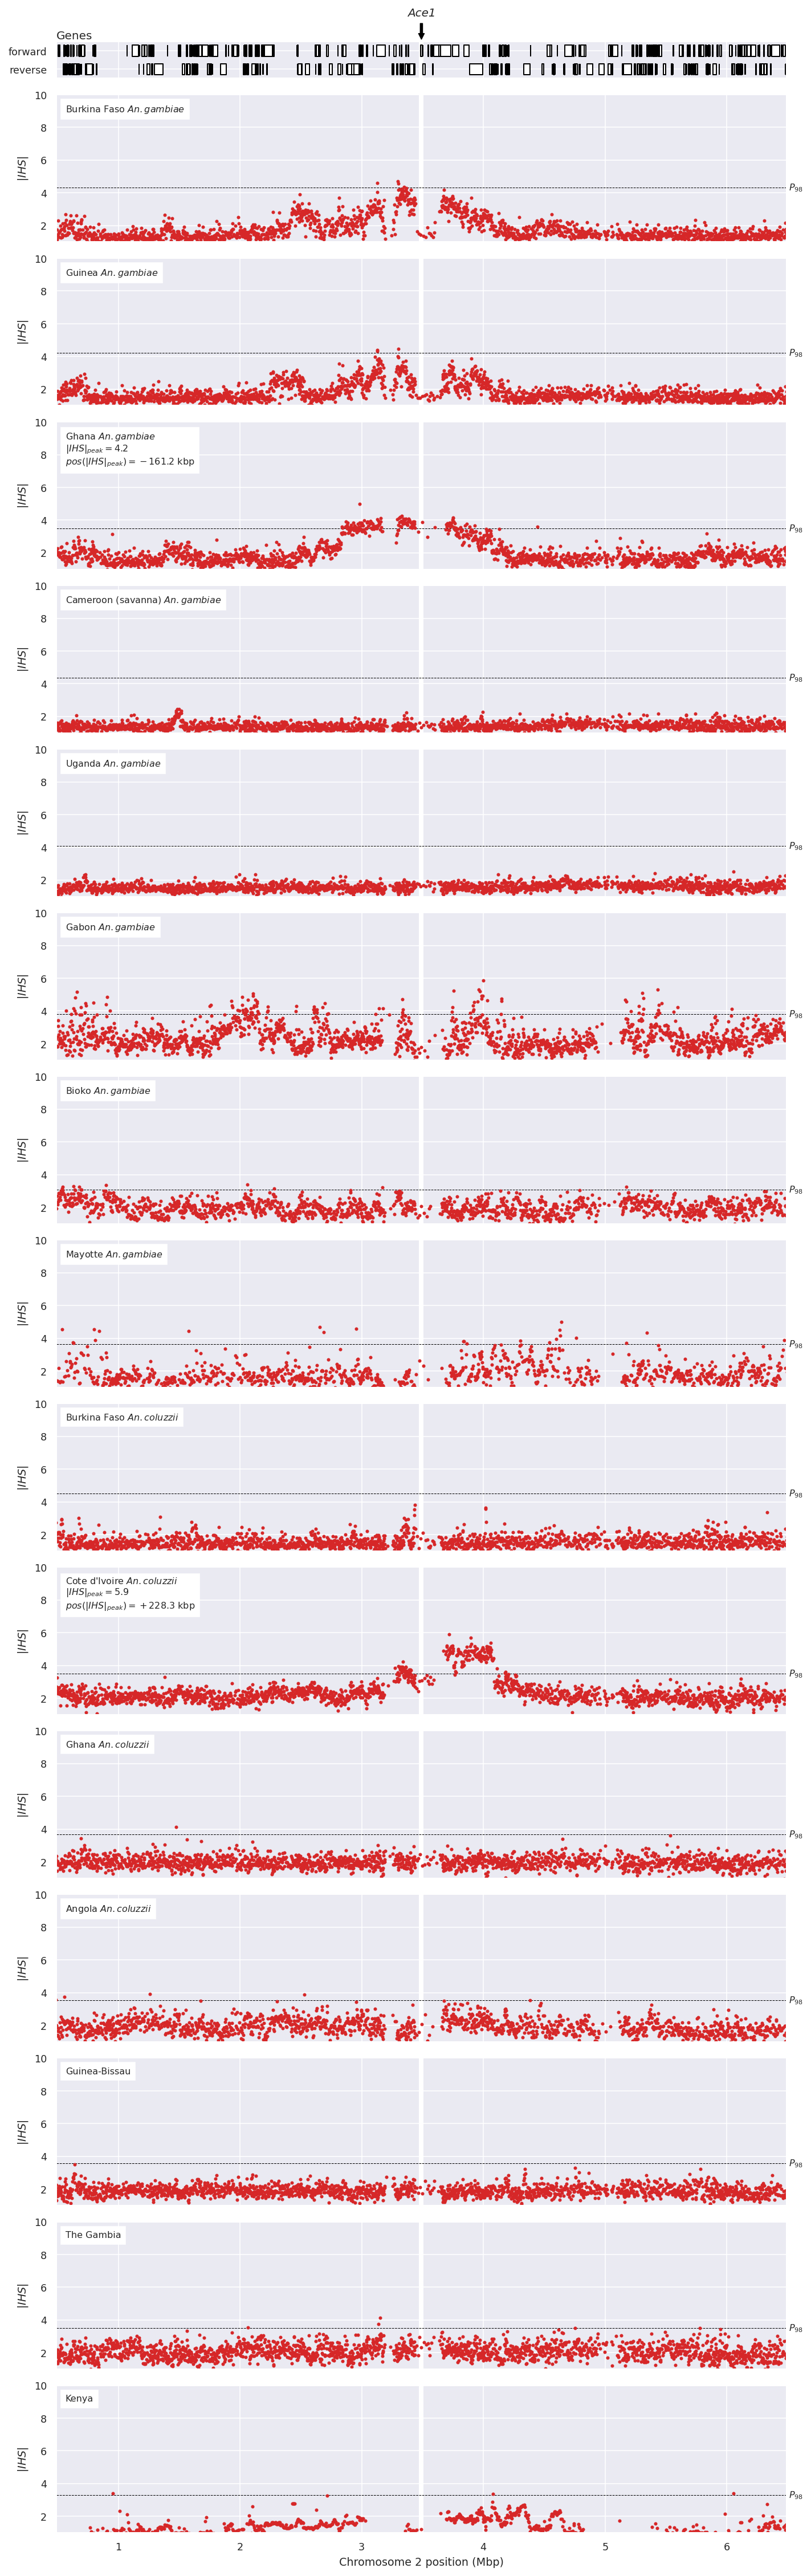

In [35]:
analyse_gene(ace1)

## Compile statistics

In [36]:
analyse_peak_stats(all_stats, slug='ihs', label='|IHS|')